In [36]:
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Load data
data_features = pd.read_csv('./data/dengue_features_train.csv')
data_labels = pd.read_csv('./data/dengue_labels_train.csv')
data_test = pd.read_csv('./data/dengue_features_test.csv')

# San Juan Data

In [37]:
# Features
data_features_sj = data_features[data_features.city=='sj'].reset_index(drop = True)
data_labels_sj = data_labels[data_labels.city=='sj'].reset_index(drop = True)
data_sj = pd.merge(data_features_sj, data_labels_sj)
data_sj = data_sj.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg'])

data_sj = data_sj.fillna(method = 'ffill')
data_sj['month'] = pd.to_datetime(data_sj['week_start_date']).dt.month
data_sj['odd_year'] = data_sj.year.astype('int64') % 2 == 1
data_sj['ndvi_mean'] = (data_sj['ndvi_ne'] + data_sj['ndvi_nw'] + data_sj['ndvi_se'] + data_sj['ndvi_sw']) / 4.0


data_sj['ndvi_mean_rolling_avg'] = data_sj['ndvi_mean'].rolling(window = 50).mean()
data_sj['ndvi_ne_rolling_avg'] = data_sj['ndvi_ne'].rolling(window = 50).mean()
data_sj['ndvi_nw_rolling_avg'] = data_sj['ndvi_nw'].rolling(window = 50).mean()
data_sj['ndvi_se_rolling_avg'] = data_sj['ndvi_se'].rolling(window = 50).mean()
data_sj['ndvi_sw_rolling_avg'] = data_sj['ndvi_sw'].rolling(window = 50).mean()
data_sj['precipitation_amt_mm_rolling_avg'] = data_sj['precipitation_amt_mm'].rolling(window = 50).mean()
data_sj['reanalysis_air_temp_k_rolling_avg'] = data_sj['reanalysis_air_temp_k'].rolling(window = 50).mean()
data_sj['reanalysis_avg_temp_k_rolling_avg'] = data_sj['reanalysis_avg_temp_k'].rolling(window = 50).mean()
data_sj['reanalysis_dew_point_temp_k_rolling_avg'] = data_sj['reanalysis_dew_point_temp_k'].rolling(window = 50).mean()
data_sj['reanalysis_max_air_temp_k_rolling_avg'] = data_sj['reanalysis_max_air_temp_k'].rolling(window = 50).mean()
data_sj['reanalysis_min_air_temp_k_rolling_avg'] = data_sj['reanalysis_min_air_temp_k'].rolling(window = 50).mean()
data_sj['reanalysis_precip_amt_kg_per_m2_rolling_avg'] = data_sj['reanalysis_precip_amt_kg_per_m2'].rolling(window = 50).mean()
data_sj['reanalysis_relative_humidity_percent_rolling_avg'] = data_sj['reanalysis_relative_humidity_percent'].rolling(window = 50).mean()
data_sj['reanalysis_tdtr_k_rolling_avg'] = data_sj['reanalysis_tdtr_k'].rolling(window = 50).mean()
data_sj['station_avg_temp_c_rolling_avg'] = data_sj['station_avg_temp_c'].rolling(window = 50).mean()
data_sj['station_diur_temp_rng_c_rolling_avg'] = data_sj['station_diur_temp_rng_c'].rolling(window = 50).mean()
data_sj['station_max_temp_c_rolling_avg'] = data_sj['station_max_temp_c'].rolling(window = 50).mean()
data_sj['station_min_temp_c_rolling_avg'] = data_sj['station_min_temp_c'].rolling(window = 50).mean()
data_sj['station_precip_mm_rolling_avg'] = data_sj['station_precip_mm'].rolling(window = 50).mean()


data_sj['week_start_date'] = pd.to_datetime(data_sj['week_start_date']).dt.month


data_sj.drop(data_sj.head(50).index, inplace=True)

# data_labels_sj_year = data_labels_sj.groupby(['year'])['total_cases'].stdev().to_frame(name = 'annual_cases').reset_index()
# data_labels_sj = pd.merge(data_labels_sj, data_labels_sj_year)
# data_labels_sj['pct_cases_year'] = data_labels_sj['total_cases'] / data_labels_sj['annual_cases']


# Features - Normalize
data_sj_n = MinMaxScaler().fit_transform(data_sj[data_sj.columns[4:43]])
data_sj_n = pd.DataFrame(data_sj_n, columns = data_sj.columns[4:43], index=data_sj.index)
data_sj_n = data_sj_n.drop(columns=['total_cases'])
data_sj_n['month'] = data_sj['month']
data_sj_n['odd_year'] = data_sj['odd_year']


# Features Test
data_sj_last50week = data_features[data_features.city=='sj'].reset_index(drop = True).tail(50)
data_test_sj = data_test[data_test.city=='sj'].reset_index(drop = True)
frames = [data_sj_last50week, data_test_sj]
data_test_sj = pd.concat(frames).reset_index(drop = True)

data_test_sj = data_test_sj.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg'])
data_test_sj = data_test_sj.fillna(method = 'ffill')
data_test_sj['month'] = pd.to_datetime(data_test_sj['week_start_date']).dt.month
data_test_sj['odd_year'] = data_test_sj.year.astype('int64') % 2 == 1
data_test_sj['ndvi_mean'] = (data_test_sj['ndvi_ne'] + data_test_sj['ndvi_nw'] + data_test_sj['ndvi_se'] + data_test_sj['ndvi_sw']) / 4.0

data_test_sj['ndvi_mean_rolling_avg'] = data_test_sj['ndvi_mean'].rolling(window = 50).mean()
data_test_sj['ndvi_ne_rolling_avg'] = data_test_sj['ndvi_ne'].rolling(window = 50).mean()
data_test_sj['ndvi_nw_rolling_avg'] = data_test_sj['ndvi_nw'].rolling(window = 50).mean()
data_test_sj['ndvi_se_rolling_avg'] = data_test_sj['ndvi_se'].rolling(window = 50).mean()
data_test_sj['ndvi_sw_rolling_avg'] = data_test_sj['ndvi_sw'].rolling(window = 50).mean()
data_test_sj['precipitation_amt_mm_rolling_avg'] = data_test_sj['precipitation_amt_mm'].rolling(window = 50).mean()
data_test_sj['reanalysis_air_temp_k_rolling_avg'] = data_test_sj['reanalysis_air_temp_k'].rolling(window = 50).mean()
data_test_sj['reanalysis_avg_temp_k_rolling_avg'] = data_test_sj['reanalysis_avg_temp_k'].rolling(window = 50).mean()
data_test_sj['reanalysis_dew_point_temp_k_rolling_avg'] = data_test_sj['reanalysis_dew_point_temp_k'].rolling(window = 50).mean()
data_test_sj['reanalysis_max_air_temp_k_rolling_avg'] = data_test_sj['reanalysis_max_air_temp_k'].rolling(window = 50).mean()
data_test_sj['reanalysis_min_air_temp_k_rolling_avg'] = data_test_sj['reanalysis_min_air_temp_k'].rolling(window = 50).mean()
data_test_sj['reanalysis_precip_amt_kg_per_m2_rolling_avg'] = data_test_sj['reanalysis_precip_amt_kg_per_m2'].rolling(window = 50).mean()
data_test_sj['reanalysis_relative_humidity_percent_rolling_avg'] = data_test_sj['reanalysis_relative_humidity_percent'].rolling(window = 50).mean()
data_test_sj['reanalysis_tdtr_k_rolling_avg'] = data_test_sj['reanalysis_tdtr_k'].rolling(window = 50).mean()
data_test_sj['station_avg_temp_c_rolling_avg'] = data_test_sj['station_avg_temp_c'].rolling(window = 50).mean()
data_test_sj['station_diur_temp_rng_c_rolling_avg'] = data_test_sj['station_diur_temp_rng_c'].rolling(window = 50).mean()
data_test_sj['station_max_temp_c_rolling_avg'] = data_test_sj['station_max_temp_c'].rolling(window = 50).mean()
data_test_sj['station_min_temp_c_rolling_avg'] = data_test_sj['station_min_temp_c'].rolling(window = 50).mean()
data_test_sj['station_precip_mm_rolling_avg'] = data_test_sj['station_precip_mm'].rolling(window = 50).mean()

data_test_sj.drop(data_test_sj.head(50).index, inplace=True)

# Features Test - Normalized
data_test_sj_n = MinMaxScaler().fit_transform(data_test_sj[data_test_sj.columns[4:43]])
data_test_sj_n = pd.DataFrame(data_test_sj_n, columns = data_test_sj.columns[4:43], index=data_test_sj.index)
data_test_sj_n['month'] = data_test_sj['month']
data_test_sj_n['odd_year'] = data_test_sj['odd_year']

# Iquitos Data

In [38]:
# Features
data_features_iq = data_features[data_features.city=='iq'].reset_index(drop = True)
data_labels_iq = data_labels[data_labels.city=='iq'].reset_index(drop = True)
data_iq = pd.merge(data_features_iq, data_labels_iq)
data_iq = data_iq.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg'])

data_iq = data_iq.fillna(method = 'ffill')
data_iq['month'] = pd.to_datetime(data_iq['week_start_date']).dt.month
data_iq['odd_year'] = data_iq.year.astype('int64') % 2 == 1
data_iq['ndvi_mean'] = (data_iq['ndvi_ne'] + data_iq['ndvi_nw'] + data_iq['ndvi_se'] + data_iq['ndvi_sw']) / 4.0



data_iq['ndvi_mean_rolling_avg'] = data_iq['ndvi_mean'].rolling(window = 50).mean()
data_iq['ndvi_ne_rolling_avg'] = data_iq['ndvi_ne'].rolling(window = 50).mean()
data_iq['ndvi_nw_rolling_avg'] = data_iq['ndvi_nw'].rolling(window = 50).mean()
data_iq['ndvi_se_rolling_avg'] = data_iq['ndvi_se'].rolling(window = 50).mean()
data_iq['ndvi_sw_rolling_avg'] = data_iq['ndvi_sw'].rolling(window = 50).mean()
data_iq['precipitation_amt_mm_rolling_avg'] = data_iq['precipitation_amt_mm'].rolling(window = 50).mean()
data_iq['reanalysis_air_temp_k_rolling_avg'] = data_iq['reanalysis_air_temp_k'].rolling(window = 50).mean()
data_iq['reanalysis_avg_temp_k_rolling_avg'] = data_iq['reanalysis_avg_temp_k'].rolling(window = 50).mean()
data_iq['reanalysis_dew_point_temp_k_rolling_avg'] = data_iq['reanalysis_dew_point_temp_k'].rolling(window = 50).mean()
data_iq['reanalysis_max_air_temp_k_rolling_avg'] = data_iq['reanalysis_max_air_temp_k'].rolling(window = 50).mean()
data_iq['reanalysis_min_air_temp_k_rolling_avg'] = data_iq['reanalysis_min_air_temp_k'].rolling(window = 50).mean()
data_iq['reanalysis_precip_amt_kg_per_m2_rolling_avg'] = data_iq['reanalysis_precip_amt_kg_per_m2'].rolling(window = 50).mean()
data_iq['reanalysis_relative_humidity_percent_rolling_avg'] = data_iq['reanalysis_relative_humidity_percent'].rolling(window = 50).mean()
data_iq['reanalysis_tdtr_k_rolling_avg'] = data_iq['reanalysis_tdtr_k'].rolling(window = 50).mean()
data_iq['station_avg_temp_c_rolling_avg'] = data_iq['station_avg_temp_c'].rolling(window = 50).mean()
data_iq['station_diur_temp_rng_c_rolling_avg'] = data_iq['station_diur_temp_rng_c'].rolling(window = 50).mean()
data_iq['station_max_temp_c_rolling_avg'] = data_iq['station_max_temp_c'].rolling(window = 50).mean()
data_iq['station_min_temp_c_rolling_avg'] = data_iq['station_min_temp_c'].rolling(window = 50).mean()
data_iq['station_precip_mm_rolling_avg'] = data_iq['station_precip_mm'].rolling(window = 50).mean()


data_iq.drop(data_iq.head(50).index, inplace=True)


# Features - Normalize
data_iq_n = MinMaxScaler().fit_transform(data_iq[data_iq.columns[4:43]])
data_iq_n = pd.DataFrame(data_iq_n, columns = data_iq.columns[4:43], index=data_iq.index)
data_iq_n = data_iq_n.drop(columns=['total_cases'])
data_iq_n['month'] = data_iq['month']
data_iq_n['odd_year'] = data_iq['odd_year']

# Features Test
data_iq_last50week = data_features[data_features.city=='iq'].reset_index(drop = True).tail(50)
data_test_iq = data_test[data_test.city=='iq'].reset_index(drop = True)
frames = [data_iq_last50week, data_test_iq]
data_test_iq = pd.concat(frames).reset_index(drop = True)

data_test_iq = data_test_iq.drop(columns=['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg'])
data_test_iq = data_test_iq.fillna(method = 'ffill')
data_test_iq['month'] = pd.to_datetime(data_iq['week_start_date']).dt.month
data_test_iq['odd_year'] = data_test_iq.year.astype('int64') % 2 == 1
data_test_iq['ndvi_mean'] = (data_test_iq['ndvi_ne'] + data_test_iq['ndvi_nw'] + data_test_iq['ndvi_se'] + data_test_iq['ndvi_sw']) / 4.0

data_test_iq['ndvi_mean_rolling_avg'] = data_test_iq['ndvi_mean'].rolling(window = 50).mean()
data_test_iq['ndvi_ne_rolling_avg'] = data_test_iq['ndvi_ne'].rolling(window = 50).mean()
data_test_iq['ndvi_nw_rolling_avg'] = data_test_iq['ndvi_nw'].rolling(window = 50).mean()
data_test_iq['ndvi_se_rolling_avg'] = data_test_iq['ndvi_se'].rolling(window = 50).mean()
data_test_iq['ndvi_sw_rolling_avg'] = data_test_iq['ndvi_sw'].rolling(window = 50).mean()
data_test_iq['precipitation_amt_mm_rolling_avg'] = data_test_iq['precipitation_amt_mm'].rolling(window = 50).mean()
data_test_iq['reanalysis_air_temp_k_rolling_avg'] = data_test_iq['reanalysis_air_temp_k'].rolling(window = 50).mean()
data_test_iq['reanalysis_avg_temp_k_rolling_avg'] = data_test_iq['reanalysis_avg_temp_k'].rolling(window = 50).mean()
data_test_iq['reanalysis_dew_point_temp_k_rolling_avg'] = data_test_iq['reanalysis_dew_point_temp_k'].rolling(window = 50).mean()
data_test_iq['reanalysis_max_air_temp_k_rolling_avg'] = data_test_iq['reanalysis_max_air_temp_k'].rolling(window = 50).mean()
data_test_iq['reanalysis_min_air_temp_k_rolling_avg'] = data_test_iq['reanalysis_min_air_temp_k'].rolling(window = 50).mean()
data_test_iq['reanalysis_precip_amt_kg_per_m2_rolling_avg'] = data_test_iq['reanalysis_precip_amt_kg_per_m2'].rolling(window = 50).mean()
data_test_iq['reanalysis_relative_humidity_percent_rolling_avg'] = data_test_iq['reanalysis_relative_humidity_percent'].rolling(window = 50).mean()
data_test_iq['reanalysis_tdtr_k_rolling_avg'] = data_test_iq['reanalysis_tdtr_k'].rolling(window = 50).mean()
data_test_iq['station_avg_temp_c_rolling_avg'] = data_test_iq['station_avg_temp_c'].rolling(window = 50).mean()
data_test_iq['station_diur_temp_rng_c_rolling_avg'] = data_test_iq['station_diur_temp_rng_c'].rolling(window = 50).mean()
data_test_iq['station_max_temp_c_rolling_avg'] = data_test_iq['station_max_temp_c'].rolling(window = 50).mean()
data_test_iq['station_min_temp_c_rolling_avg'] = data_test_iq['station_min_temp_c'].rolling(window = 50).mean()
data_test_iq['station_precip_mm_rolling_avg'] = data_test_iq['station_precip_mm'].rolling(window = 50).mean()

data_test_iq.drop(data_test_iq.head(50).index, inplace=True)

# Features Test - Normalized
data_test_iq_n = MinMaxScaler().fit_transform(data_test_iq[data_test_iq.columns[4:43]])
data_test_iq_n = pd.DataFrame(data_test_iq_n, columns = data_test_iq.columns[4:43], index=data_test_iq.index)
data_test_iq_n['month'] = data_test_iq['month']
data_test_iq_n['odd_year'] = data_test_iq['odd_year']

# Training Data

In [39]:
# San Juan
train_features_sj, test_features_sj, train_outcome_sj, test_outcome_sj = train_test_split(
    data_sj_n,
    data_sj['total_cases'],
    test_size = 0.3
)

#Iquitos
train_features_iq, test_features_iq, train_outcome_iq, test_outcome_iq = train_test_split(
    data_iq_n,
    data_iq['total_cases'],
    test_size = 0.3
)

# Feature Importance

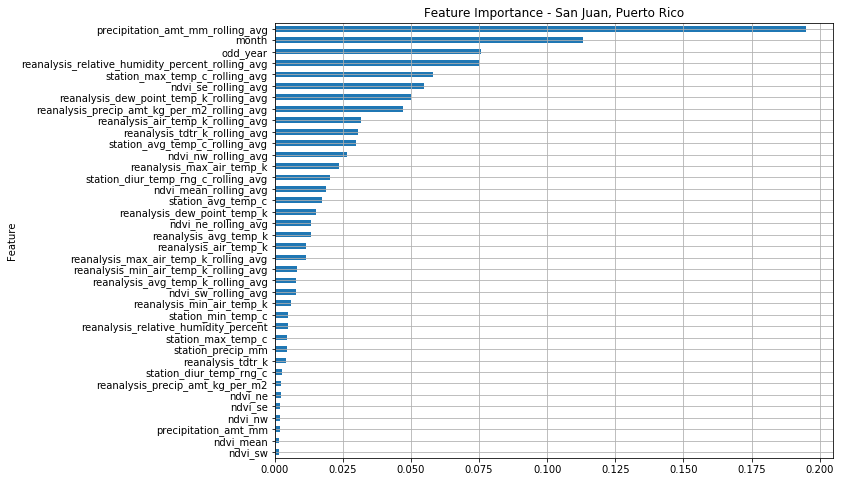

In [40]:
model = ExtraTreesRegressor()
model.fit(train_features_sj, train_outcome_sj)
feature_imp = pd.DataFrame({'Feature': data_sj_n.columns, 'Importance':model.feature_importances_})
feature_imp = feature_imp.set_index('Feature')
feature_imp
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - San Juan, Puerto Rico', grid = True, legend = False, figsize=(10,8))

In [41]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(train_features_sj, train_outcome_sj)
print(model.feature_importances_)
data_sj_n.columns[model.feature_importances_ > 0.03]

[0.00287659 0.0021009  0.01862065 0.00212712 0.00511196 0.01877452
 0.01155572 0.00498645 0.00293211 0.00501144 0.00111496 0.00527002
 0.01010328 0.00533289 0.00448028 0.00131272 0.0037212  0.00316569
 0.16544155 0.04257553 0.00214992 0.00923372 0.01113529 0.01547112
 0.01480715 0.02822016 0.21711087 0.00945923 0.01602754 0.12131405
 0.00382521 0.02300882 0.02696803 0.07830278 0.01894825 0.01964676
 0.02648376 0.04127176]


Index(['month', 'odd_year', 'precipitation_amt_mm_rolling_avg',
       'reanalysis_dew_point_temp_k_rolling_avg',
       'reanalysis_relative_humidity_percent_rolling_avg',
       'station_max_temp_c_rolling_avg'],
      dtype='object')

## Update Training Data (Using important features)

In [42]:
# San Juan
train_features_sj, test_features_sj, train_outcome_sj, test_outcome_sj = train_test_split(
    data_sj_n[['month', 'odd_year', 'ndvi_sw_rolling_avg',
       'precipitation_amt_mm_rolling_avg',
       'reanalysis_dew_point_temp_k_rolling_avg',
       'reanalysis_precip_amt_kg_per_m2_rolling_avg',
       'reanalysis_relative_humidity_percent_rolling_avg',
       'station_diur_temp_rng_c_rolling_avg',
       'station_max_temp_c_rolling_avg']],
    data_sj['total_cases'],
    test_size = 0.3
)

# K Nearest Neighbors

# San Juan

## Grid Search (Find optimal neighbors)

In [43]:
params = {'n_neighbors':range(2, 50), 'weights':['uniform', 'distance']}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=params, cv=folds, scoring='neg_mean_absolute_error')
grid_search.fit(train_features_sj, train_outcome_sj)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 50), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [44]:
grid_search.score(test_features_sj, test_outcome_sj)
grid_search.cv_results_['params'][grid_search.best_index_]

{'n_neighbors': 2, 'weights': 'distance'}

In [45]:
train_features_small, validation_features, train_outcome_small, validation_outcome = train_test_split(
    train_features_sj,
    train_outcome_sj,
    test_size=0.2
)

abs_error = {}
for k in range(1,20,1) :
    knn_reg = KNeighborsRegressor(n_neighbors=k, weights = 'distance')
    knn_preds = knn_reg.fit(train_features_small, train_outcome_small).predict(validation_features)
    abs_error[k] = mean_absolute_error(knn_preds, validation_outcome)
abs_error

{1: 8.766129032258064,
 2: 7.8767431341260865,
 3: 7.760100830739607,
 4: 7.776299247789519,
 5: 8.122565878639291,
 6: 8.202178984661357,
 7: 8.499374231881541,
 8: 8.508378020683553,
 9: 8.506700177025236,
 10: 8.782214318265613,
 11: 8.84399315961472,
 12: 9.066613135132007,
 13: 9.312747348241636,
 14: 9.565287073778004,
 15: 9.75797666512627,
 16: 9.888700812637108,
 17: 9.97710626800415,
 18: 10.02348564791402,
 19: 9.916058588599888}

In [46]:
# Fit the model to our (training) data, and use it to predict on our *test data*
knr_reg = KNeighborsRegressor(n_neighbors = 4, weights = 'distance')
knr_preds_sj = knr_reg.fit(train_features_sj, train_outcome_sj).predict(test_features_sj)
print(mean_absolute_error(test_outcome_sj, knr_preds_sj))

8.398079463046177


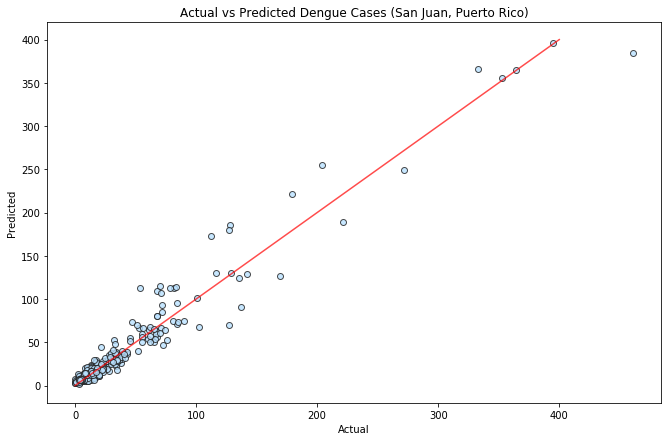

In [47]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (San Juan, Puerto Rico)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcome_sj, knr_preds_sj, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 400], [0, 400], 'red', alpha=0.7)

In [48]:
knr_preds_final_sj = knr_reg.fit(train_features_sj, train_outcome_sj).predict(
    data_test_sj_n[['month', 'odd_year', 'ndvi_sw_rolling_avg',
       'precipitation_amt_mm_rolling_avg',
       'reanalysis_dew_point_temp_k_rolling_avg',
       'reanalysis_precip_amt_kg_per_m2_rolling_avg',
       'reanalysis_relative_humidity_percent_rolling_avg',
       'station_diur_temp_rng_c_rolling_avg',
       'station_max_temp_c_rolling_avg']]
)

In [49]:
submission_sj = data_test_sj[['city', 'year', 'weekofyear']].copy()
submission_sj['total_cases'] = np.round(knr_preds_final_sj).astype(int)

# Iquitos

# Feature Selection

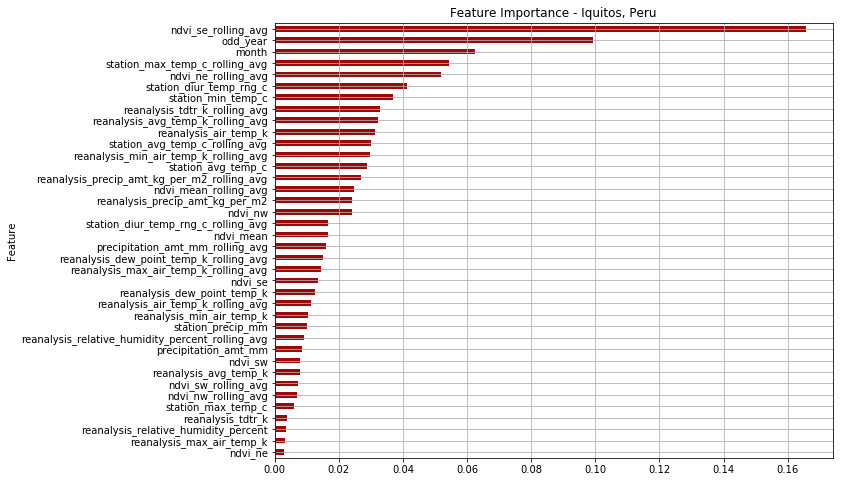

In [50]:
model = ExtraTreesRegressor()
model.fit(train_features_iq, train_outcome_iq)
feature_imp = pd.DataFrame({'Feature': data_iq_n.columns, 'Importance':model.feature_importances_})
feature_imp = feature_imp.set_index('Feature')
feature_imp
feature_imp.sort_values(by='Importance').plot(kind='barh', title='Feature Importance - Iquitos, Peru', grid = True, legend = False, color = '#9b0a0a', figsize=(10,8))

In [51]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(train_features_iq, train_outcome_iq)
print(model.feature_importances_)
data_sj_n.columns[model.feature_importances_ > 0.03]

[0.01549087 0.02745423 0.01628553 0.00493198 0.01342151 0.0299425
 0.00851656 0.01141263 0.00844824 0.00829621 0.06940539 0.01231785
 0.01337361 0.00903417 0.02645288 0.00615123 0.01081639 0.00552355
 0.0827359  0.1062564  0.00330221 0.03753056 0.01970648 0.01924872
 0.12557023 0.00913828 0.00416794 0.02732762 0.0486646  0.00742252
 0.02469228 0.02579973 0.01822055 0.00809851 0.02057338 0.06230863
 0.01853486 0.03342529]


Index(['reanalysis_precip_amt_kg_per_m2', 'month', 'odd_year',
       'ndvi_mean_rolling_avg', 'ndvi_se_rolling_avg',
       'reanalysis_avg_temp_k_rolling_avg', 'station_avg_temp_c_rolling_avg',
       'station_max_temp_c_rolling_avg'],
      dtype='object')

# Update Training Data

In [52]:
#Iquitos
train_features_iq, test_features_iq, train_outcome_iq, test_outcome_iq = train_test_split(
    data_iq_n[['reanalysis_avg_temp_k', 'month', 'odd_year', 'ndvi_nw_rolling_avg',
       'ndvi_sw_rolling_avg', 'reanalysis_max_air_temp_k_rolling_avg',
       'reanalysis_tdtr_k_rolling_avg', 'station_diur_temp_rng_c_rolling_avg',
       'station_max_temp_c_rolling_avg']],
    data_iq['total_cases'],
    test_size = 0.3
)

# Grid Search

In [53]:
params = {'n_neighbors':range(2, 50), 'weights':['uniform', 'distance']}
folds = KFold(n_splits = 10, shuffle=True)
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=params, cv=folds, return_train_score=True)
grid_search.fit(train_features_iq, train_outcome_iq)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 50), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [54]:
grid_search.score(test_features_iq, test_outcome_iq)
grid_search.cv_results_['params'][grid_search.best_index_]

{'n_neighbors': 16, 'weights': 'distance'}

In [55]:
train_features_small, validation_features, train_outcome_small, validation_outcome = train_test_split(
    train_features_iq,
    train_outcome_iq,
    test_size=0.2
)

abs_error = {}
for k in range(1,20,1) :
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_preds = knn_reg.fit(train_features_small, train_outcome_small).predict(validation_features)
    abs_error[k] = mean_absolute_error(knn_preds, validation_outcome)
abs_error

{1: 10.757575757575758,
 2: 7.893939393939394,
 3: 6.85858585858586,
 4: 6.556818181818182,
 5: 6.790909090909092,
 6: 7.083333333333332,
 7: 6.91991341991342,
 8: 6.607954545454546,
 9: 6.616161616161616,
 10: 6.445454545454546,
 11: 6.329201101928375,
 12: 6.301767676767677,
 13: 6.144522144522145,
 14: 6.164502164502165,
 15: 6.1454545454545455,
 16: 6.071969696969697,
 17: 6.097147950089127,
 18: 6.113636363636363,
 19: 6.1355661881977674}

In [56]:
# Fit the model to our (training) data, and use it to predict on our *test data*
knr_reg = KNeighborsRegressor(n_neighbors = 4, weights = 'distance')
knr_preds_iq = knr_reg.fit(train_features_iq, train_outcome_iq).predict(test_features_iq)
print(mean_absolute_error(test_outcome_iq, knr_preds_iq))

4.095113088045437


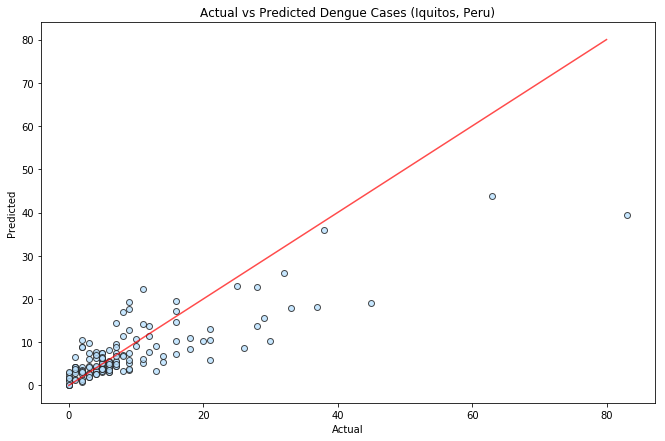

In [57]:
plt.subplots(figsize=(11,7))
plt.title('Actual vs Predicted Dengue Cases (Iquitos, Peru)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.scatter(test_outcome_iq, knr_preds_iq, edgecolors = '#1e1e1e', color='#bae1ff', alpha=0.8)
plt.plot([0, 80], [0, 80], 'red', alpha=0.7)

In [58]:
knr_preds_final_iq = knr_reg.fit(train_features_iq, train_outcome_iq).predict(
    data_test_iq_n[['reanalysis_avg_temp_k', 'month', 'odd_year', 'ndvi_nw_rolling_avg',
       'ndvi_sw_rolling_avg', 'reanalysis_max_air_temp_k_rolling_avg',
       'reanalysis_tdtr_k_rolling_avg', 'station_diur_temp_rng_c_rolling_avg',
       'station_max_temp_c_rolling_avg']]
)

In [59]:
submission_iq = data_test_iq[['city', 'year', 'weekofyear']].copy()
submission_iq['total_cases'] = np.round(knr_preds_final_iq).astype(int)

## Submission

In [60]:
frames = [submission_sj, submission_iq]
submission = pd.concat(frames)
submission.to_csv('knn.csv', index = False)